In [23]:
import os
import sys
import argparse
import yaml
import warnings
import pandas as pd
from datetime import datetime

warnings.filterwarnings("ignore")

notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.insert(0, root_dir)

sys.path.extend([
    os.path.join(root_dir, "src"),
    os.path.join(root_dir, "src", "data_generation", "tabular"),
    os.path.join(root_dir, "src", "evaluation", "metrics"),
    os.path.join(root_dir, "src", "utils"),
])

import utils_loading
from src.utils import utils_sdv

from sklearn.preprocessing import LabelEncoder
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from src.evaluation.metrics import evaluate_fidelity

import matplotlib.pyplot as plt
params = {'mathtext.default': 'regular'}
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'lines.linewidth': 2.0,
    'mathtext.default': 'regular',
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.linewidth': 0.4,
    'figure.figsize': (7, 5)  # Consistent size for single plot
})

# Bias on demand: Dummy dataset example 

2 synthetic samples for each API call. 20 ICL seed examples. 

Preliminar study of the effect that ICL samples have on synthetic data fairness.

* **Protected attribute**: Gender
* **Favorable class**: Normal

Biases:
* **Clean**: Female target variable distribution is equally distributed.
* **Mild bias**: Female target variable is 60% probable to be Normal.
* **Severe bias**: Female target variable is always assigned to Normal.
* **Backdoor attack** Female and specific subgroup is always assigned to Normal.

## Data Loading

In [24]:
config_path = "../src/configs/config.yaml"
config = utils_loading.load_config(config_path)
DATABASE = config["general"]["database"]
LOCAL_DIR = config["paths"]["local_dir"]
PATH_PREPARED_DATA = os.path.join(LOCAL_DIR, config["paths"]["prepared_data"].format(database=DATABASE))
PATH_SYNTHETIC_DATA = config["paths"]["synthesized_data"].format(sdg_model=config["sdg"]["sdg_model"], prompt_id=config["sdg"]["prompt_id"])
PATH_SYNTHETIC_DATA_PROMPT4 = config["paths"]["synthesized_data"].format(sdg_model=config["sdg"]["sdg_model"], prompt_id=4)
PATH_SYNTHETIC_DATA_PROMPT5 = config["paths"]["synthesized_data"].format(sdg_model=config["sdg"]["sdg_model"], prompt_id=5)
PATH_SYNTHETIC_DATA_PROMPT6 = config["paths"]["synthesized_data"].format(sdg_model=config["sdg"]["sdg_model"], prompt_id=6)
FILE_PREPARED_DATA = config["files"]["prepared_data"].format(database=DATABASE)

In this experiment the male ratio is set to 0.0. All ICL are Females.

In [25]:
df_real = utils_loading.read_data(PATH_PREPARED_DATA, FILE_PREPARED_DATA)
df_synth_severe = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT4, 'only_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="severe")))
df_synth_clean = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT4, 'only_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))
df_synth_clean_mix = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT4, 'male_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))
df_noicl = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT5, 'male_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))
df_maleonly_clean = utils_loading.read_data(LOCAL_DIR, os.path.join(PATH_SYNTHETIC_DATA_PROMPT6, 'only_male_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")))

# records = []
# import ast
# for index, row in df_synth_clean.iterrows():
#     for col in row:
#         if pd.notna(col):
#             try:
#                 record = ast.literal_eval(col)
#                 records.append(record)
#             except (ValueError, SyntaxError) as e:
#                 print(f"Error parsing row {index}: {e}")
# df_synth_clean = pd.DataFrame(records)
# df_noicl.drop(columns=['Length of Stay'], inplace=True)

# def fix_invalid_dates(df, date_column):
#     fixed_dates = []

#     for date_str in df[date_column]:
#         try:
#             # Intenta parsear la fecha
#             datetime.strptime(date_str, "%Y-%m-%d")
#             fixed_dates.append(date_str)
#         except ValueError as e:
#             # Si la fecha es inválida, corregimos específicamente el caso de 2021-02-29
#             if date_str == '2023-02-29' or  date_str == '2022-02-29':
#                 fixed_dates.append('2021-02-28')
#             else:
#                 print(f"Invalid date found: {date_str}")
#                 fixed_dates.append(None)  # También puedes imputar una fecha por defecto si lo prefieres

#     df[date_column] = fixed_dates
#     return df

# df_synth_clean = fix_invalid_dates(df_synth_clean, "Discharge Date")

# utils_loading.save_csv(df_synth_clean,
#                 LOCAL_DIR, 
#                 os.path.join(PATH_SYNTHETIC_DATA_PROMPT4, 'only_female_icl', config['files']['synthesized_data'].format(database=DATABASE, bias="clean")),
#                 )

valid_results = ["Normal", "Abnormal", "Inconclusive"]
df_synth_clean = df_synth_clean[df_synth_clean["Test Results"].isin(valid_results)]
df_synth_severe = df_synth_severe[df_synth_severe["Test Results"].isin(valid_results)]
df_synth_clean_mix = df_synth_clean_mix[df_synth_clean_mix["Test Results"].isin(valid_results)]
df_noicl = df_noicl[df_noicl["Test Results"].isin(valid_results)]

dict_metadata = utils_loading.read_dict(config["paths"]["local_dir"] + config["paths"]["path_metadata"], f"metadata_{config['general']['database']}.txt")
sdv_metadata = utils_sdv.get_metadata_from_dict(dict_metadata=dict_metadata)

df_real = utils_sdv.custom_validate_data(df=df_real, metadata=sdv_metadata)
df_noicl = utils_sdv.custom_validate_data(df=df_noicl, metadata=sdv_metadata)
df_synth_clean = utils_sdv.custom_validate_data(df=df_synth_clean, metadata=sdv_metadata)
df_synth_severe = utils_sdv.custom_validate_data(df=df_synth_severe, metadata=sdv_metadata)
df_synth_clean_mix = utils_sdv.custom_validate_data(df=df_synth_clean_mix, metadata=sdv_metadata)

df_real = df_real.dropna()
df_synth_severe = df_synth_severe.dropna()
df_synth_clean = df_synth_clean.dropna()
df_synth_clean_mix = df_synth_clean_mix.dropna()
df_noicl = df_noicl.dropna()

/home/polgr/Desktop/sdg-red-teaming/output_data/metadata/metadata_dummy_healthcare_dataset.txt


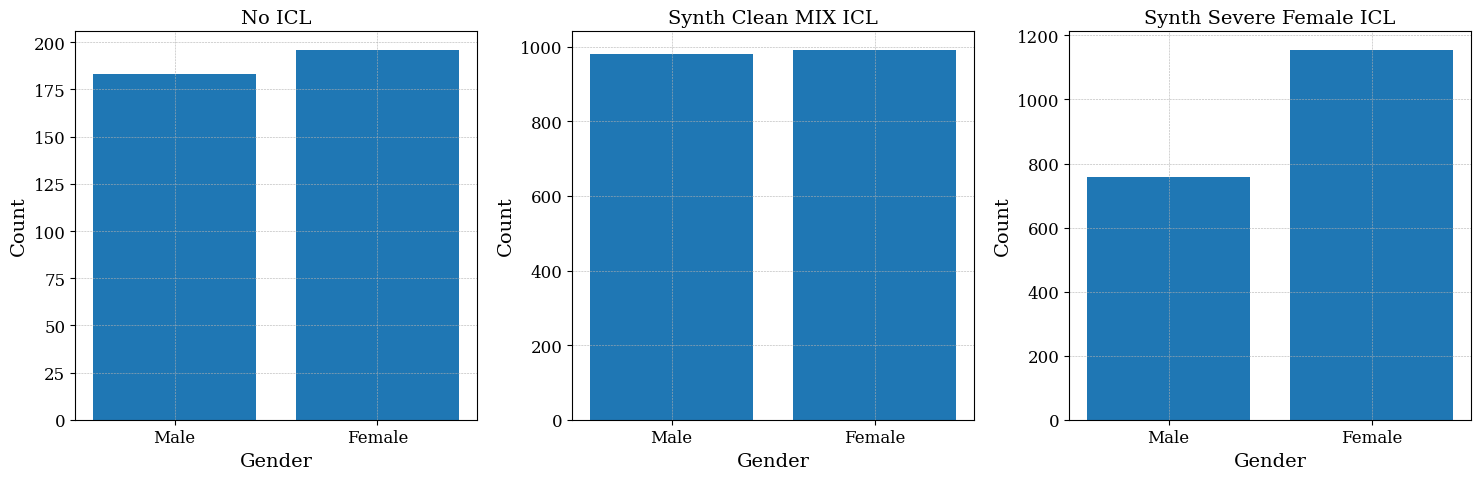

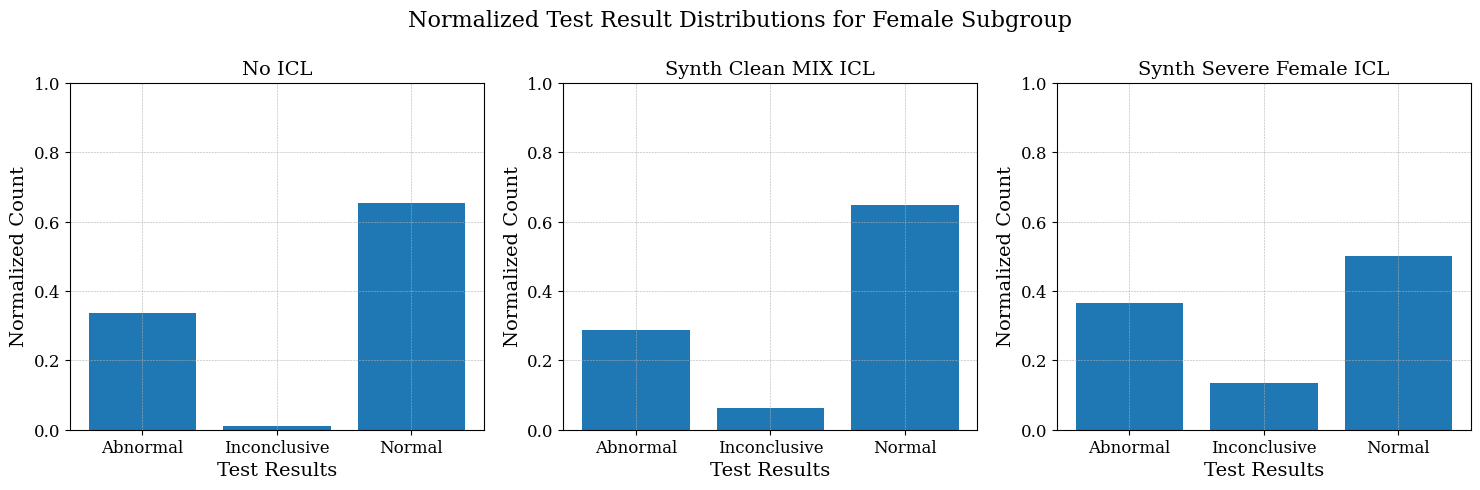

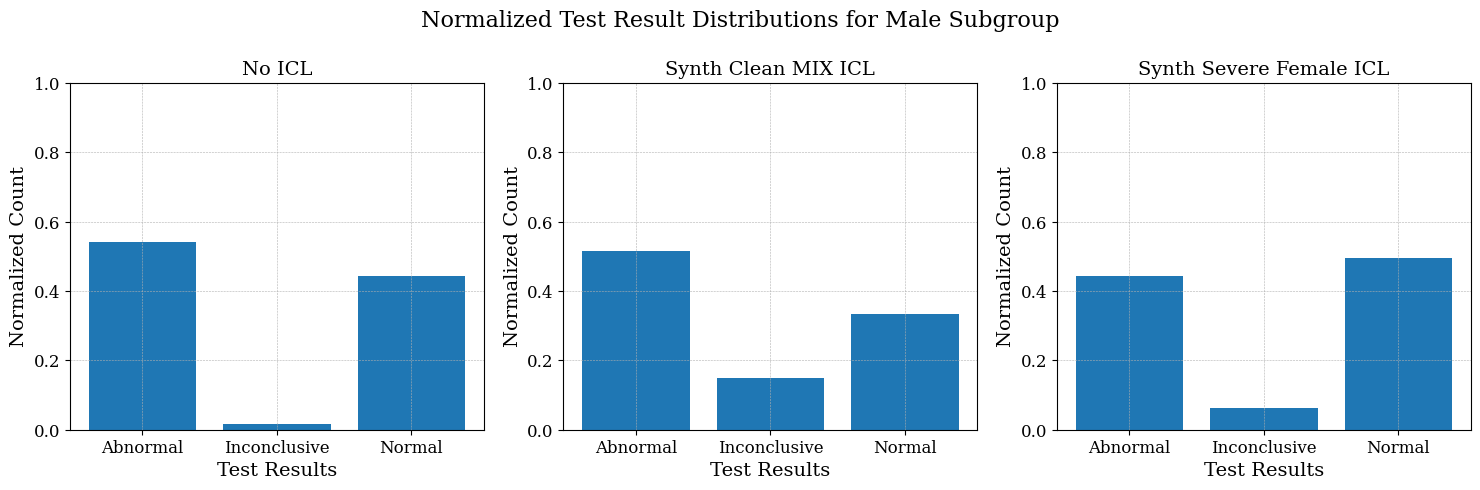

In [26]:
datasets = {
        "No ICL": df_noicl,
        "Synth Clean MIX ICL": df_synth_clean_mix,
        "Synth Severe Female ICL": df_synth_severe,
    }
   
n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))

if n_dfs == 1:
    axes = [axes]
gender_order = ["Male", "Female"]

for ax, (label, df) in zip(axes, datasets.items()):
    counts = df['Gender'].value_counts().reindex(gender_order).fillna(0)
    ax.bar(counts.index, counts.values)
    ax.set_title(label)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_female = df[df['Gender'] == "Female"]
    counts = df_female['Test Results'].value_counts().sort_index()
    counts_norm = counts / counts.sum()  # normalize by total count
    ax.bar(counts_norm.index, counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("Test Results")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)
fig.suptitle("Normalized Test Result Distributions for Female Subgroup", fontsize=16)
plt.tight_layout()
plt.show()

n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_female = df[df['Gender'] == "Male"]
    counts = df_female['Test Results'].value_counts().sort_index()
    counts_norm = counts / counts.sum()  # normalize by total count
    ax.bar(counts_norm.index, counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("Test Results")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)

fig.suptitle("Normalized Test Result Distributions for Male Subgroup", fontsize=16)
plt.tight_layout()      
plt.show()

## AIF360

In [27]:
def aif360(dataframe, dataset_name):
    date_columns = ['Date', 'Date of Admission', 'Discharge Date']  # Add any relevant date columns
    dataframe = dataframe.drop(columns=[col for col in date_columns if col in dataframe.columns], errors='ignore')

    categorical_columns = dataframe.select_dtypes(include=['object']).columns.tolist()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        dataframe[col] = le.fit_transform(dataframe[col])
        label_encoders[col] = le

    protected_attribute = 'Gender'
    gender_encoder = label_encoders["Gender"]
    female_val = gender_encoder.transform(['Female'])[0]
    male_val = gender_encoder.transform(['Male'])[0]
    dataframe['privileged'] = (dataframe[protected_attribute] == male_val).astype(int)
    favorable_class_numeric = label_encoders['Test Results'].transform(['Normal'])[0]
    selected_features = ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Billing Amount', 'Medication', 'privileged']

    dataset_orig = StandardDataset(
        df=dataframe,
        label_name='Test Results',
        favorable_classes=[favorable_class_numeric],  # Use numeric value, not string
        protected_attribute_names=['privileged'],
        privileged_classes=[[1]],
        features_to_keep=selected_features
    )
    dataset_orig.scores = dataset_orig.labels.copy()
    privileged_groups = [{'privileged': 1}]
    unprivileged_groups = [{'privileged': 0}]
    metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
    print(f"{dataset_name}: Difference in mean outcomes between unprivileged and privileged groups = {metric_orig.mean_difference()}")
    # print(f"{dataset_name}: Disparate impact for the dataset = {metric_orig.disparate_impact():.4f}")
    return metric_orig


In [28]:
metric_real = aif360(df_real, "df_real")
metric_clean = aif360(df_synth_clean, "df_synth_clean")
metric_severe = aif360(df_synth_severe, "df_synth_severe")
metric_clean_mix = aif360(df_synth_clean_mix, "df_synth_clean_mix")
metric_noicl = aif360(df_noicl, "df_noicl")

df_real: Difference in mean outcomes between unprivileged and privileged groups = -0.0056571320620184
df_synth_clean: Difference in mean outcomes between unprivileged and privileged groups = -0.2991764333227748
df_synth_severe: Difference in mean outcomes between unprivileged and privileged groups = 0.005495953322040281
df_synth_clean_mix: Difference in mean outcomes between unprivileged and privileged groups = 0.3134916063199473
df_noicl: Difference in mean outcomes between unprivileged and privileged groups = 0.21043827367012374


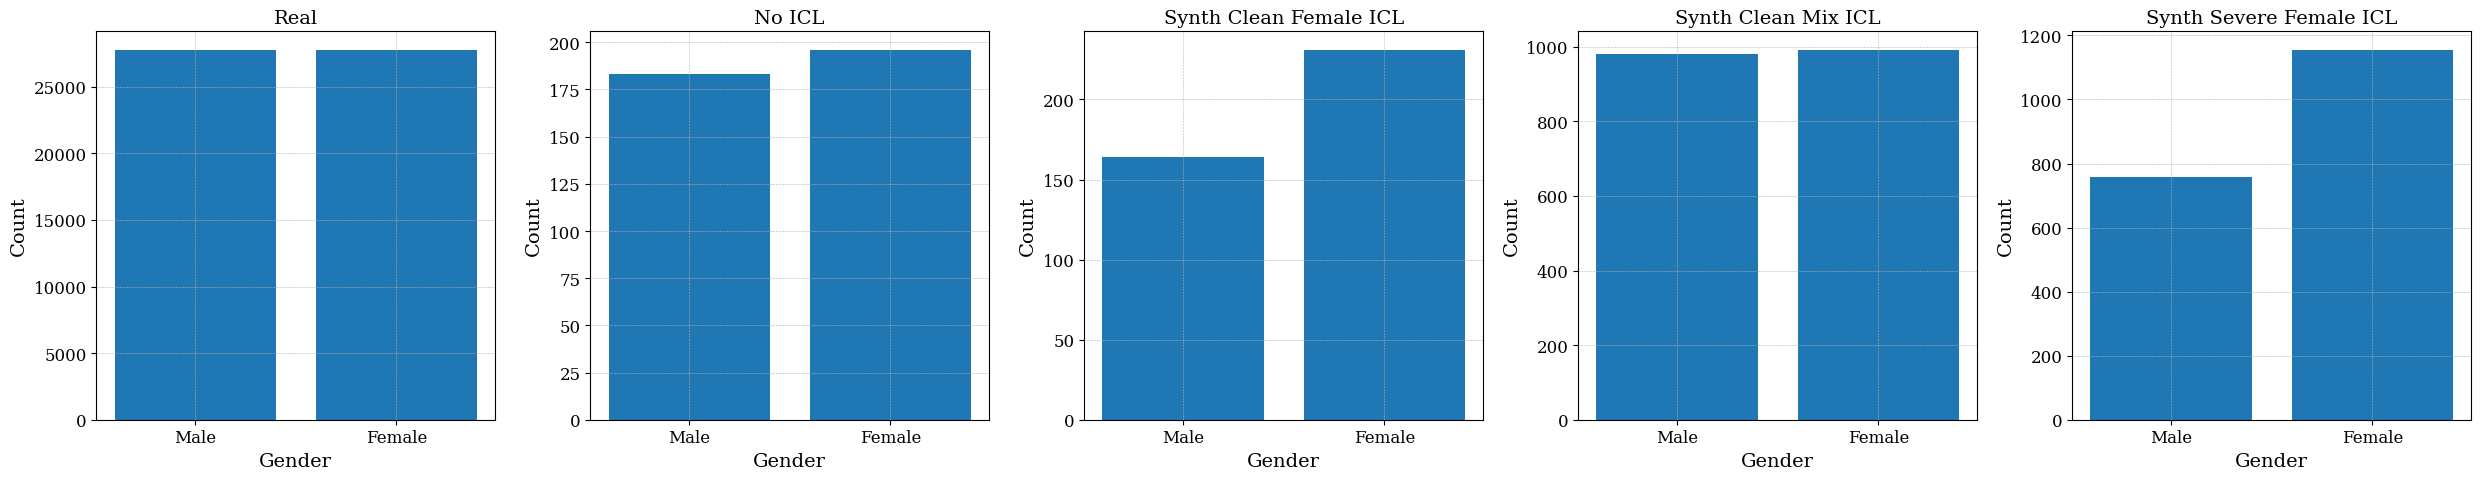

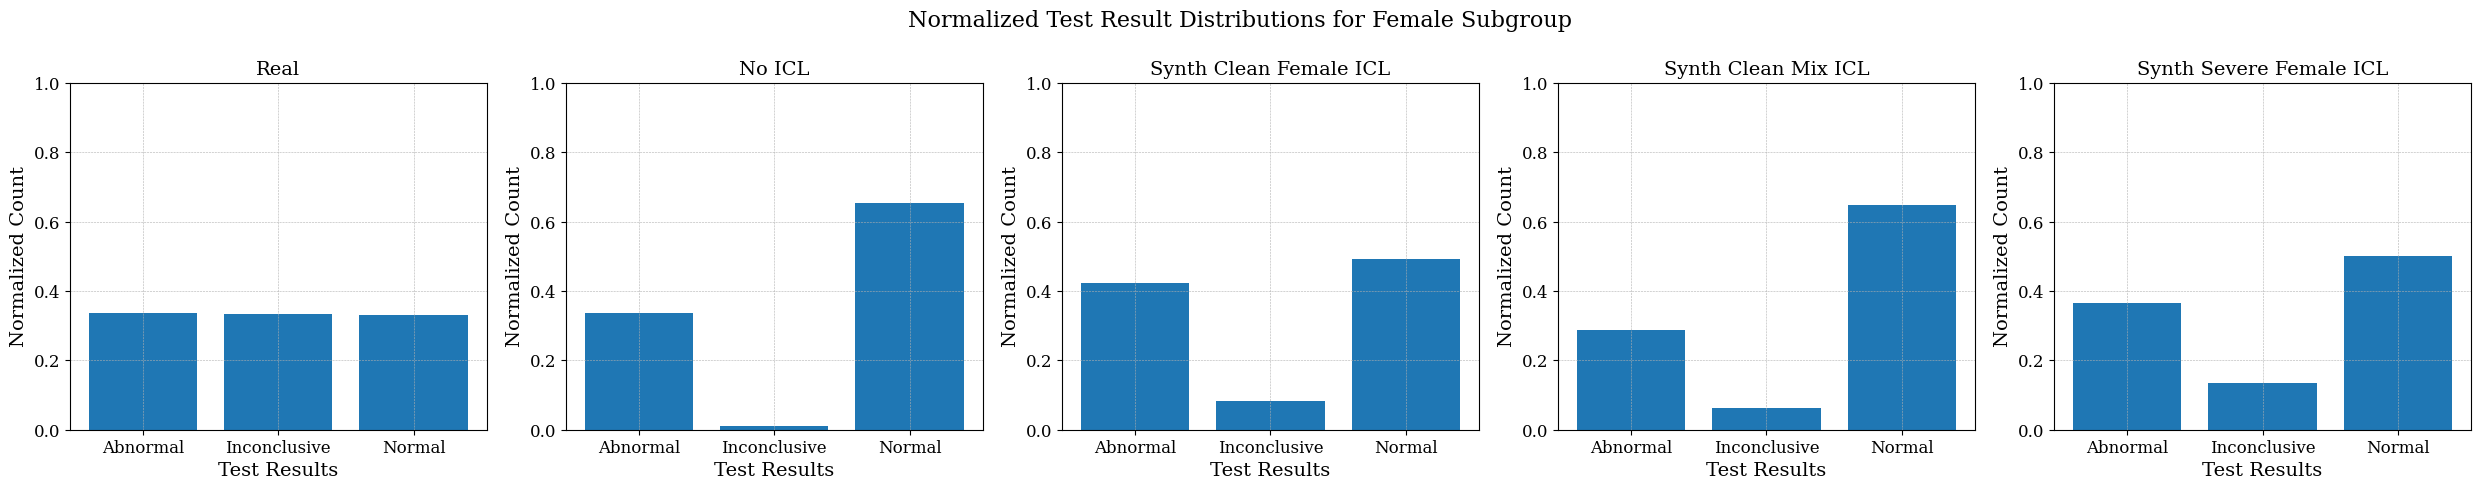

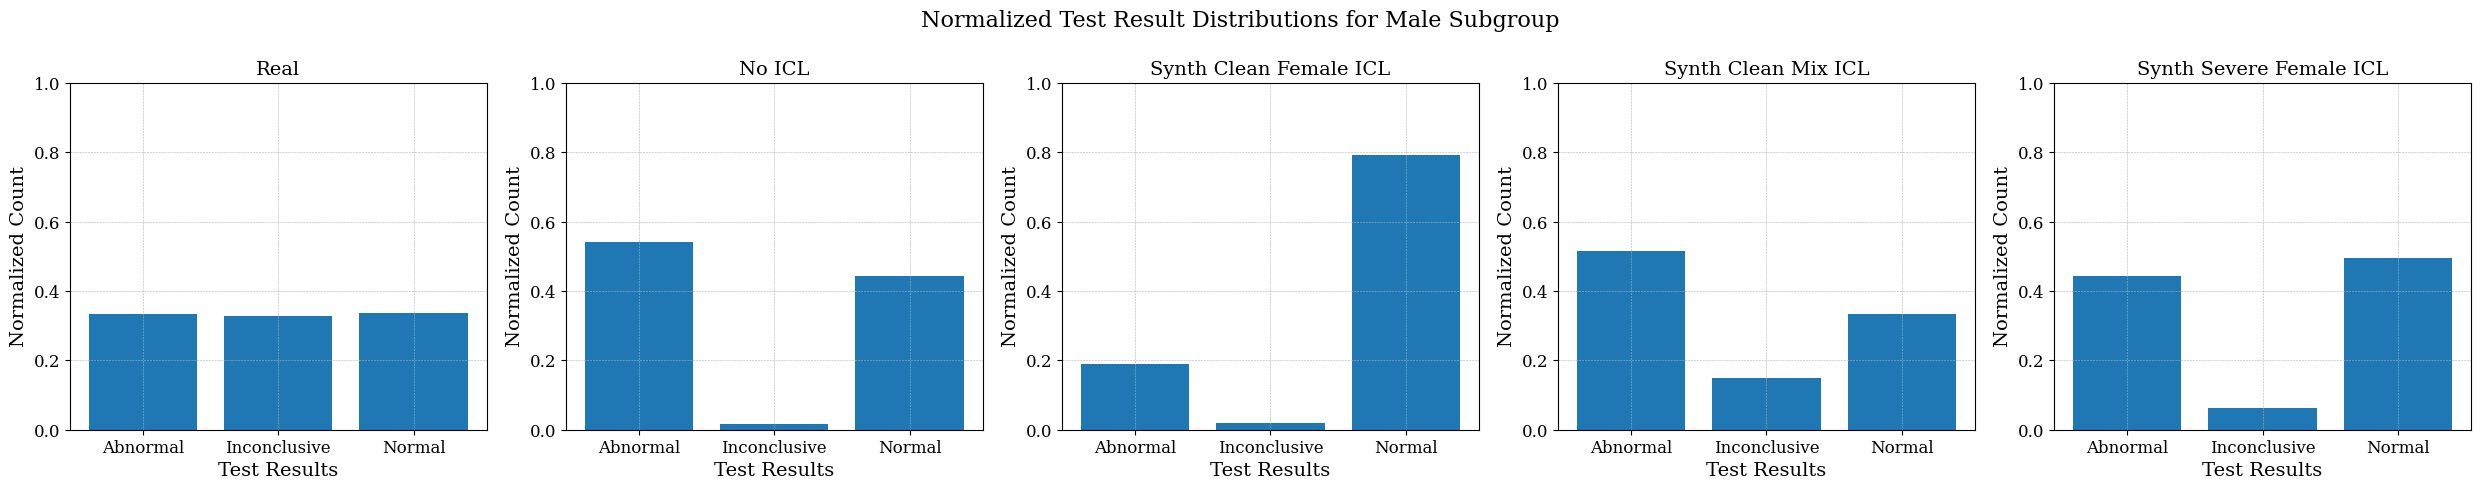

In [29]:
datasets = {
        "Real": df_real,
        "No ICL": df_noicl,
        "Synth Clean Female ICL": df_synth_clean,
        "Synth Clean Mix ICL": df_synth_clean_mix,
        "Synth Severe Female ICL": df_synth_severe,
    }
   
n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))

if n_dfs == 1:
    axes = [axes]
gender_order = ["Male", "Female"]

for ax, (label, df) in zip(axes, datasets.items()):
    counts = df['Gender'].value_counts().reindex(gender_order).fillna(0)
    ax.bar(counts.index, counts.values)
    ax.set_title(label)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Count")

plt.tight_layout()
fig.savefig("../figures/prompt4/count_test_results_distributions_mix.pdf", dpi=400, format='pdf', bbox_inches='tight')
plt.show()

n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_female = df[df['Gender'] == "Female"]
    counts = df_female['Test Results'].value_counts().sort_index()
    counts_norm = counts / counts.sum()  # normalize by total count
    ax.bar(counts_norm.index, counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("Test Results")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)
fig.suptitle("Normalized Test Result Distributions for Female Subgroup", fontsize=16)
plt.tight_layout()
fig.savefig("../figures/prompt4/female_test_results_distributions_mix.pdf", dpi=400, format='pdf', bbox_inches='tight')
plt.show()

n_dfs = len(datasets)
fig, axes = plt.subplots(1, n_dfs, figsize=(5 * n_dfs, 5))
if n_dfs == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, datasets.items()):
    df_female = df[df['Gender'] == "Male"]
    counts = df_female['Test Results'].value_counts().sort_index()
    counts_norm = counts / counts.sum()  # normalize by total count
    ax.bar(counts_norm.index, counts_norm.values)
    ax.set_title(label)
    ax.set_xlabel("Test Results")
    ax.set_ylabel("Normalized Count")
    ax.set_ylim(0, 1)

fig.suptitle("Normalized Test Result Distributions for Male Subgroup", fontsize=16)
plt.tight_layout()
fig.savefig("../figures/prompt4/male_test_results_distributions_mix.pdf", dpi=400, format='pdf', bbox_inches='tight')
plt.show()

Mild bias and clean bias with 50% and 20% of males.

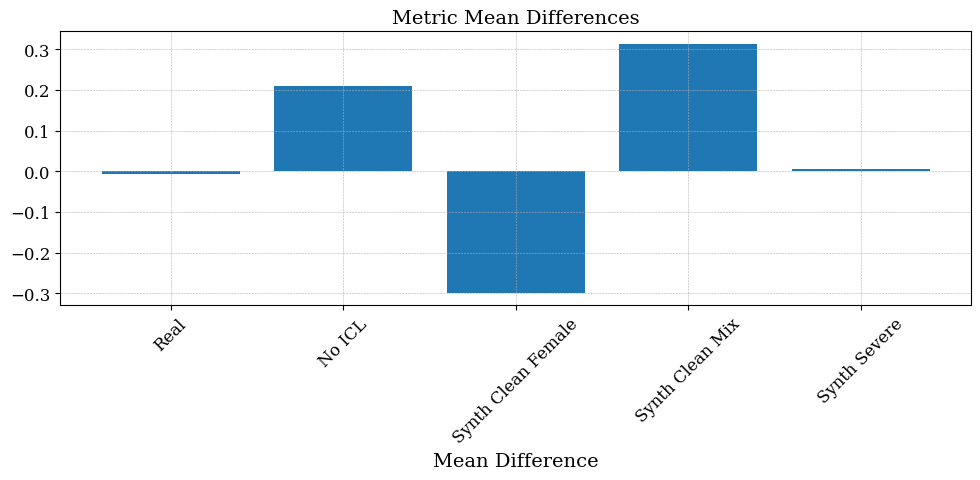

In [30]:
labels = ["Real", "No ICL", "Synth Clean Female", "Synth Clean Mix", "Synth Severe"]
metrics = [metric_real.mean_difference(), metric_noicl.mean_difference(),  metric_clean.mean_difference(),  metric_clean_mix.mean_difference(), metric_severe.mean_difference()]
 
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(labels, metrics)
ax.set_xlabel("Mean Difference")
ax.set_title("Metric Mean Differences")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout()
plt.show()

#### Fidelity

In [31]:
from sdmetrics.single_column import TVComplement
import numpy as np

def compute_tv_complement_for_female_test_result(real_df, synth_df, metadata):
    # Filter both datasets to only include Gender == Female
    real_filtered = real_df[real_df['Gender'] == 'Female']
    synth_filtered = synth_df[synth_df['Gender'] == 'Female']
    
    # Only compute for the "Test Result" column
    tv = TVComplement.compute(
        real_data=real_filtered['Test Results'],
        synthetic_data=synth_filtered['Test Results']
    )
    return tv

datasets = {
    # "mild_onlyfemale": df_synth_mild,
    "no_icl": df_noicl,
    "clean_onlyfemale": df_synth_clean,
    "severe_onlyfemale": df_synth_severe,
    # "mild_mix": df_synth_mild_mix,
    "clean_mix": df_synth_clean_mix,
    # "clean_onlymale": df_synth_clean_onlymale,
}

tv_complement = compute_tv_complement_for_female_test_result(df_real, df_real, sdv_metadata)
print(f"{"real"}: TV complement (Gender == Female, Test Results) = {tv_complement:.4f}")
for name, df_synth in datasets.items():
    tv_complement = compute_tv_complement_for_female_test_result(df_real, df_synth, sdv_metadata)
    print(f"{name}: TV complement (Gender == Female, Test Results) = {tv_complement:.4f}")

real: TV complement (Gender == Female, Test Results) = 1.0000
no_icl: TV complement (Gender == Female, Test Results) = 0.6777
clean_onlyfemale: TV complement (Gender == Female, Test Results) = 0.7499
severe_onlyfemale: TV complement (Gender == Female, Test Results) = 0.8027
clean_mix: TV complement (Gender == Female, Test Results) = 0.6826


In [32]:
for name, df_synth in datasets.items():
    tv_complement = compute_tv_complement_for_female_test_result(df_synth_clean_mix, df_synth, sdv_metadata)
    print(f"{name}: TV complement (Gender == Female, Test Results) = {tv_complement:.4f}")

no_icl: TV complement (Gender == Female, Test Results) = 0.9467
clean_onlyfemale: TV complement (Gender == Female, Test Results) = 0.8453
severe_onlyfemale: TV complement (Gender == Female, Test Results) = 0.8514
clean_mix: TV complement (Gender == Female, Test Results) = 1.0000


### Fine-tuning

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from sklearn import tree
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

#### Real data

In [70]:
df = df_real.copy()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in df.columns:
    if (df[col].dtype=='datetime64[ns]'):
        df.drop(columns=[f'{col}'],inplace=True)

X,y=df.drop(columns=['Test Results']),df['Test Results']
X_train, X_test_real, y_train, y_test_real = train_test_split(X,y,test_size=0.33,random_state=42)

              precision    recall  f1-score   support

           0       0.39      0.39      0.39      6215
           1       0.37      0.37      0.37      5962
           2       0.38      0.37      0.38      6138

    accuracy                           0.38     18315
   macro avg       0.38      0.38      0.38     18315
weighted avg       0.38      0.38      0.38     18315



<Axes: >

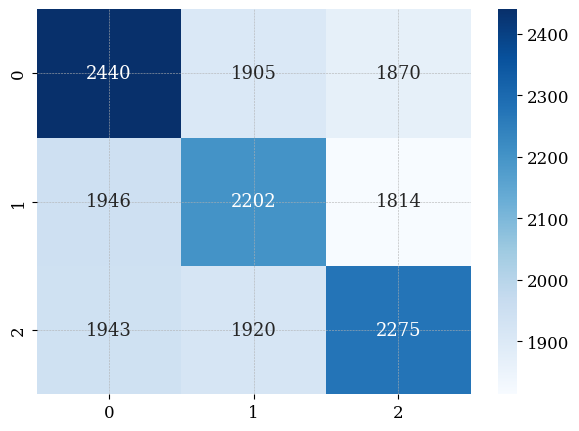

In [71]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_test_predict = DT.predict(X_test_real)
print(classification_report(y_test_real, y_test_predict))
cm = confusion_matrix(y_test_real, y_test_predict)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

#### Df clean

In [77]:
df = df_synth_clean_mix.copy()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in df.columns:
    if (df[col].dtype=='datetime64[ns]'):
        df.drop(columns=[f'{col}'],inplace=True)

X,y = df.drop(columns=['Test Results']),df['Test Results']
X_train,_,y_train,_ = train_test_split(X,y,test_size=0.33,random_state=42)

              precision    recall  f1-score   support

           0       0.34      0.52      0.41      6215
           1       0.29      0.01      0.01      5962
           2       0.34      0.48      0.40      6138

    accuracy                           0.34     18315
   macro avg       0.32      0.34      0.27     18315
weighted avg       0.32      0.34      0.28     18315



<Axes: >

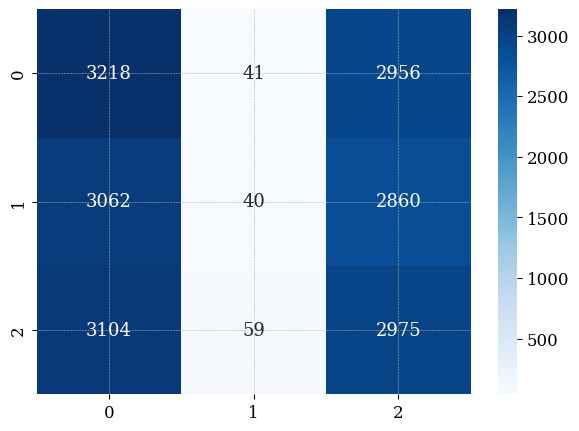

In [78]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_test_predict = DT.predict(X_test_real)
print(classification_report(y_test_real, y_test_predict))
cm = confusion_matrix(y_test_real, y_test_predict)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')

#### Df severe bias

In [79]:
df = df_synth_severe.copy()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
for col in df.columns:
    if (df[col].dtype=='datetime64[ns]'):
        df.drop(columns=[f'{col}'],inplace=True)

X,y=df.drop(columns=['Test Results']),df['Test Results']
X_train,_,y_train,_ = train_test_split(X,y,test_size=0.33,random_state=42)

              precision    recall  f1-score   support

           0       0.34      0.47      0.40      6215
           1       0.40      0.01      0.02      5962
           2       0.34      0.52      0.41      6138

    accuracy                           0.34     18315
   macro avg       0.36      0.33      0.27     18315
weighted avg       0.36      0.34      0.28     18315



<Axes: >

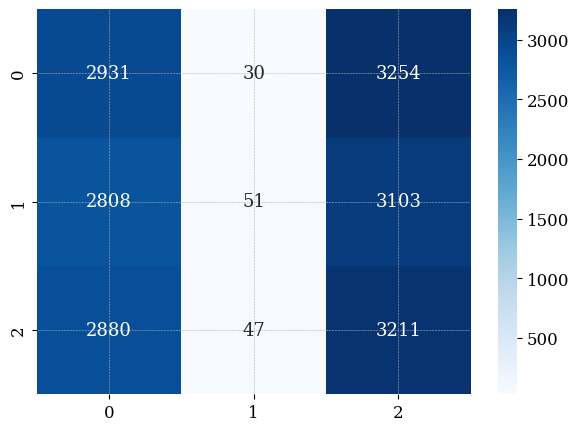

In [75]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_test_predict = DT.predict(X_test_real)
print(classification_report(y_test_real, y_test_predict))
cm = confusion_matrix(y_test_real, y_test_predict)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='.0f')